In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

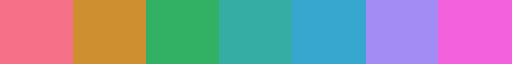

In [3]:
cmap_subset

### Coverage-Cost Experiments

In [4]:
fname = "../data/experiments/climate/coverage_exp.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2], index_col=0)

In [5]:
# Computing statistics:
grouped = experiment_df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [10]:
mean_df['normalized-clustering-cost'].columns

Index(['ExKMC-Forest', 'Forest', 'Forest-Depth-5', 'Oblique-Forest', 'SVM',
       'Voronoi'],
      dtype='object')

In [6]:
table_df = mean_df.iloc[0,:].to_frame()
table_df

0
coverage                      ExKMC-Forest       0.677674
                              Forest             0.639128
                              Forest-Depth-5     0.829855
                              Oblique-Forest     0.680552
                              SVM                0.826977
                              Voronoi            0.624331
distance-ratio                ExKMC-Forest       1.037365
                              Forest             1.209505
                              Forest-Depth-5     1.281424
                              Oblique-Forest     1.239198
                              SVM                1.234854
                              Voronoi            1.143956
normalized-clustering-cost    ExKMC-Forest      14.123524
                              Forest            10.606885
                              Forest-Depth-5    11.220690
                              Oblique-Forest    10.853663
                              SVM               11.537765
                              Voronoi           11.447156
overlap                       ExKMC-Forest       1.000000
                              Forest             1.005263
                              Forest-Depth-5     1.001398
                              Oblique-Forest     1.003230
                              SVM                1.049481
                              Voronoi            1.010743
point-average-clustering-cost ExKMC-Forest    3337.535941
                              Forest          2333.273282
                              Forest-Depth-5  3204.328336
                              Oblique-Forest  2542.306934
                              SVM             3283.559042
                              Voronoi         2463.127845
rule-length                   ExKMC-Forest       7.170000
                              Forest             2.000000
                              Forest-Depth-5     5.000000
                              Oblique-Forest     2.000000
                              SVM                1.000000
                              Voronoi            5.000000

### Plotting

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

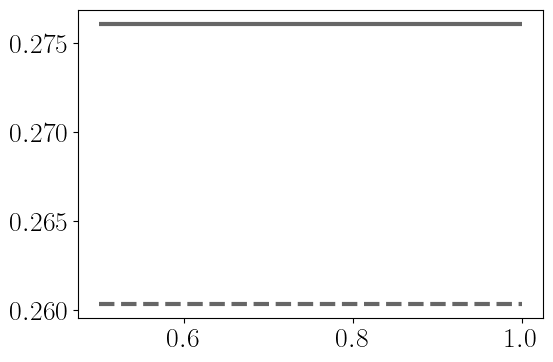

In [31]:
fname = None
#fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    xlabel = 'Required Coverage',
    ylabel = 'normalized-cost',
    domain = np.linspace(0.5,1,11),
    cmap = cmap,
    legend = True,
    filename = fname,
    baseline_list = ['KMeans', 'IMM']
)
plt.ylim(0.2,0.35)

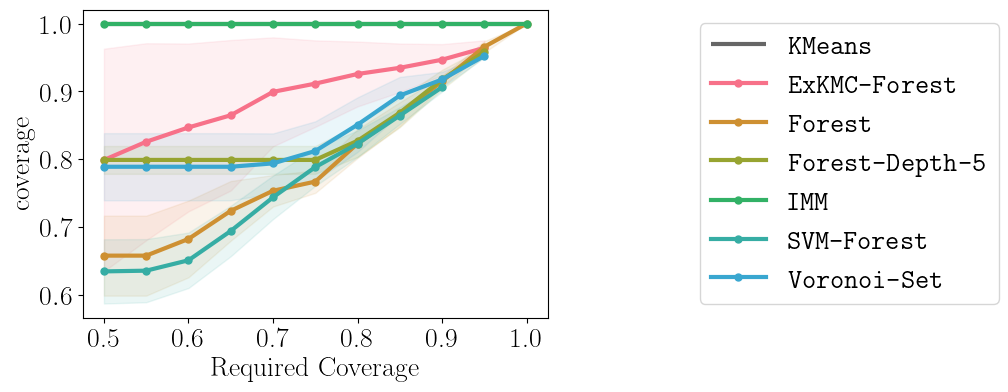

In [14]:
fname = None
#fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['coverage'],
    std_df['coverage'],
    xlabel = 'Required Coverage',
    ylabel = 'coverage',
    domain = np.linspace(0.5,1,11),
    cmap = cmap,
    legend = True,
    filename = fname
)
#plt.ylim(0.2,0.35)

(0.2, 0.35)

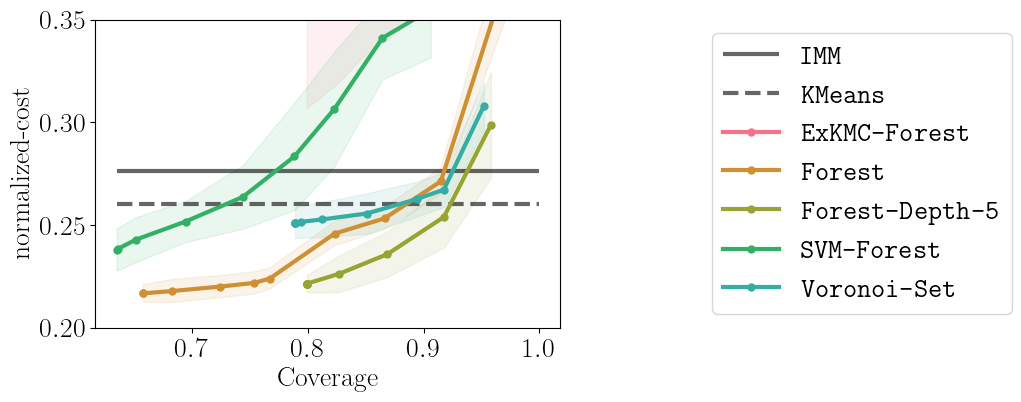

In [32]:
fname = None
#fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    xlabel = 'Coverage',
    ylabel = 'normalized-cost',
    domain = mean_df['coverage'],
    cmap = cmap,
    legend = True,
    filename = fname,
    baseline_list = ['KMeans', 'IMM']
)
plt.ylim(0.2,0.35)

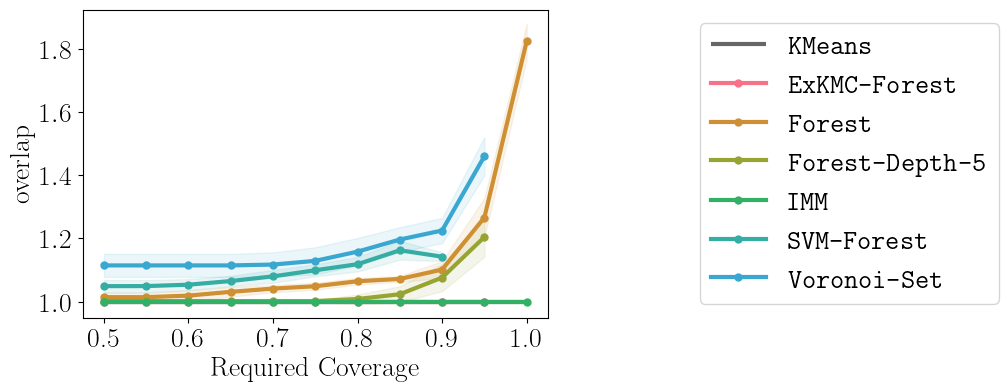

In [15]:
fname = None
#fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['overlap'],
    std_df['overlap'],
    xlabel = 'Required Coverage', 
    ylabel = 'overlap',
    domain = np.linspace(0.5,1,11),
    cmap = cmap,
    legend = True,
    filename = fname
)
#plt.ylim(0.2,0.35)

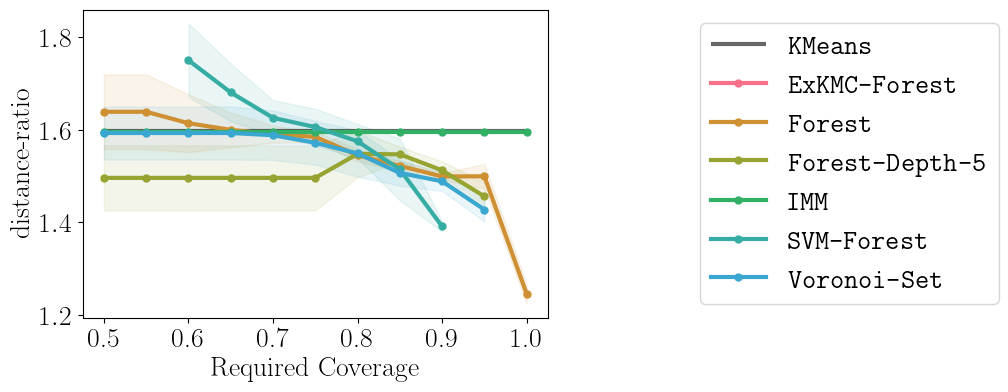

In [16]:
fname = None
#fname = '../figures/climate/normalized_cost.png'
experiment_plotter(
    mean_df['distance-ratio'],
    std_df['distance-ratio'],
    xlabel = 'Required Coverage',
    ylabel = 'distance-ratio',
    domain = np.linspace(0.5,1,11),
    cmap = cmap,
    legend = True,
    filename = fname
)
#plt.ylim(0.2,0.35)

In [17]:
mean_df['distance-ratio']

,ExKMC-Forest,Forest,Forest-Depth-5,IMM,KMeans,SVM-Forest,Voronoi-Set
0,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
1,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
2,inf,1.613986,1.495841,1.594826,1.596493,1.749947,1.592836
3,inf,1.599610,1.495841,1.594826,1.596493,1.680446,1.592836
4,inf,1.590175,1.495841,1.594826,1.596493,1.625645,1.588021
5,inf,1.584477,1.495841,1.594826,1.596493,1.605630,1.571792
6,inf,1.544779,1.547680,1.594826,1.596493,1.574870,1.548586
7,inf,1.521701,1.546777,1.594826,1.596493,1.514120,1.506670
8,inf,1.498935,1.512124,1.594826,1.596493,1.391058,1.488403
9,inf,1.499270,1.455912,1.594826,1.596493,NaN,1.427247


### Covered Cost

In [53]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

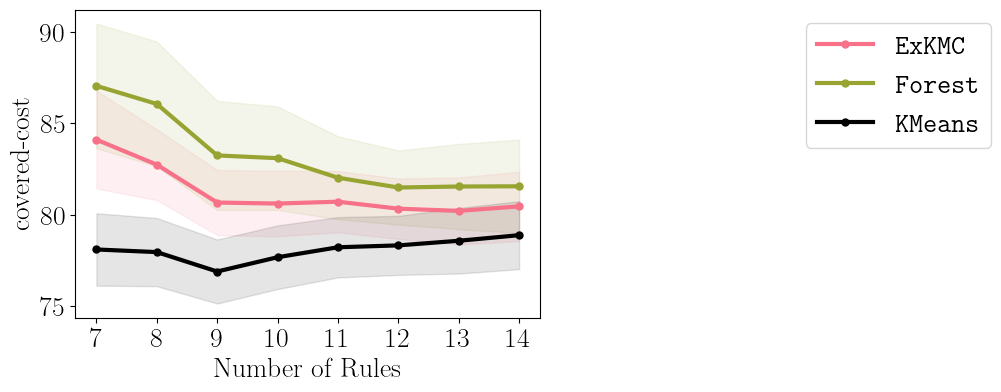

In [61]:
covered_cost_colors = [cmap(0), cmap(2), 'black']
covered_cost_colormap = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_covered_cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [59]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate_depth_5.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

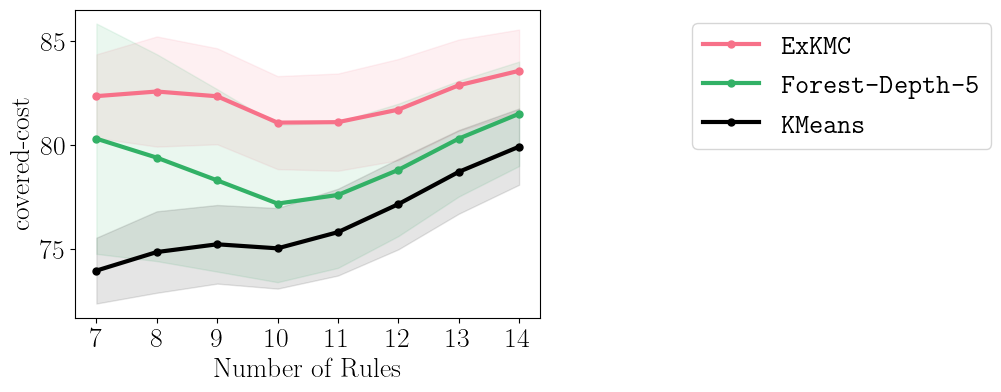

In [62]:
covered_cost_colors = [cmap(0), cmap(3), 'black']
covered_cost_colormap2 = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_d5_covered_cost.png'
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap2,
    legend = True,
    filename = fname,
    baseline_list = []
)